In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import pandas as pd

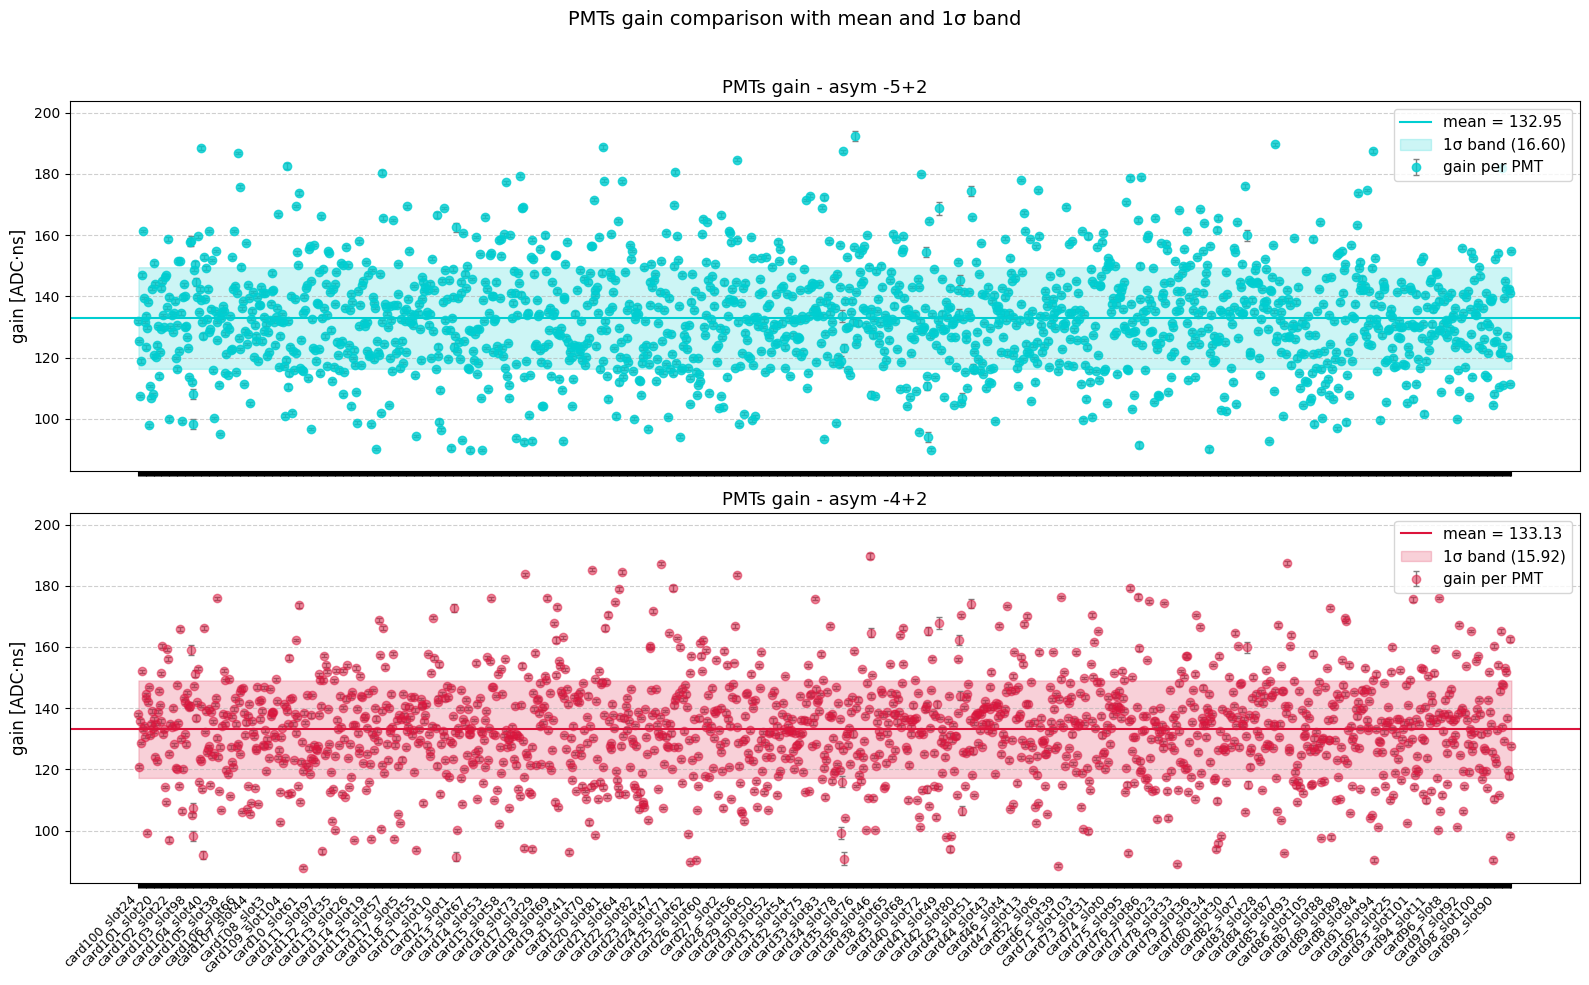

In [ ]:
#results with entire paths
files = {
    "asym -5+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_asym.npz",
    "asym -4+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_[-4,+2].npz"
}

#load results
results = {}
for label, file in files.items():
    data = np.load(file)["results"]
    results[label] = data

#pmt label = card+slot+channel
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results["asym -5+2"]:  
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

#common límites para los ejes
all_gains = []
all_errors = []
for data in results.values():
    gains = data["gain"].astype(float)
    pedestal_sigma = data["pedestal_sigma"].astype(float)
    spe_sigma = data["spe_sigma"].astype(float)
    N_pedestal = data["N_pedestal"].astype(float)
    N_spe = data["N_spe"].astype(float)

    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                          (spe_sigma/np.sqrt(N_spe))**2)

    mask = np.isfinite(gains) & np.isfinite(gain_errors)
    all_gains.append(gains[mask])
    all_errors.append(gain_errors[mask])

all_gains = np.concatenate(all_gains)
all_errors = np.concatenate(all_errors)

y_min = np.min(all_gains - all_errors) * 0.95
y_max = np.max(all_gains + all_errors) * 1.05



fig, axes = plt.subplots(2, 1, figsize=(16,10), sharex=True, sharey=True)

colors = {"asym -5+2":"darkturquoise", "asym -4+2":"crimson"}

for ax, (label, data) in zip(axes, results.items()):
    gains = data["gain"].astype(float)
    pedestal_sigma = data["pedestal_sigma"].astype(float)
    spe_sigma = data["spe_sigma"].astype(float)
    N_pedestal = data["N_pedestal"].astype(float)
    N_spe = data["N_spe"].astype(float)

    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                          (spe_sigma/np.sqrt(N_spe))**2)

    #scatter plot con error bars
    eb = ax.errorbar(
        x, gains, yerr=gain_errors,
        fmt='o', color=colors[label], ecolor='gray',
        elinewidth=1, capsize=2,
        alpha=1.0,  #alpha de las barras de error
        label="gain per PMT"
    )


    if label == "asym -4+2":
        for line in eb.lines[0:1]:  # solo los markers
            line.set_alpha(0.5)   #alpha flojo para los puntos (scatter)
    if label == "asym -5+2":
        for line in eb.lines[0:1]:
            line.set_alpha(0.8)

    #mean and std
    mean_gain = np.nanmean(gains)
    std_gain = np.nanstd(gains)

    #1_sigma band
    ax.axhline(mean_gain, color=colors[label], lw=1.5,
               label=f"mean = {mean_gain:.2f}")
    ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain,
                    color=colors[label], alpha=0.2, 
                    label=f"1σ band ({std_gain:.2f})")

    
    ax.set_ylim(y_min, y_max)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(fontsize=11, loc="upper right")
    ax.set_ylabel("gain [ADC·ns]", fontsize=12)
    ax.set_title(f"PMTs gain - {label}", fontsize=13)

axes[-1].set_xticks(ticks=x)
axes[-1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("PMTs gain comparison with mean and 1σ band", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

Guardado en relative_gain_errors_asym_-5+2.npz


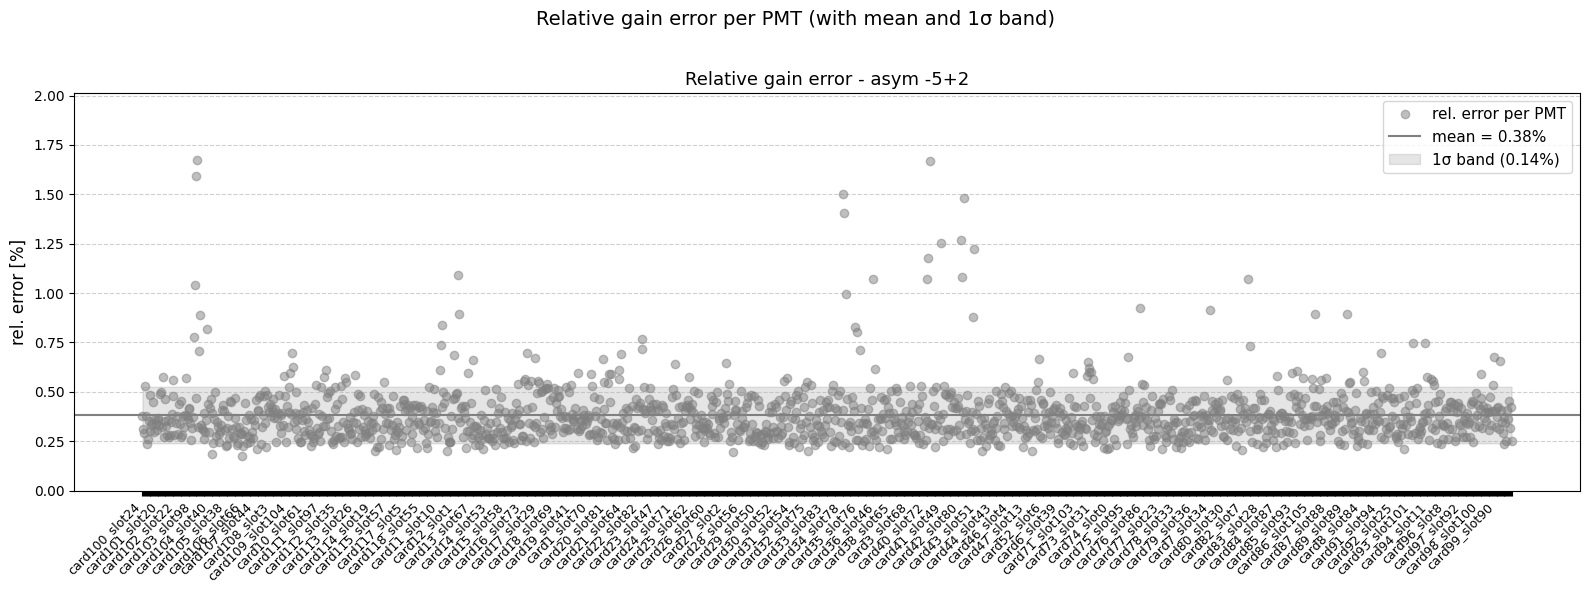

In [ ]:
#select data set of interest
label = "asym -5+2"
#label = "asym -4+2"
data = results[label]   # np.ndarray con los campos del fit

gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

#evitar divisiones por 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

#relative error (%)
rel_error = (gain_errors / gains) * 100.0
np.savez("relative_gain_errors_asym_-5+2.npz", rel_error=rel_error, x_labels=x_labels)
print("Guardado en relative_gain_errors_asym_-5+2.npz")

#np.savez("relative_gain_errors_asym_-4+2.npz", rel_error=rel_error, x_labels=x_labels)
#print("Guardado en relative_gain_errors_asym_-4+2.npz")


fig, ax = plt.subplots(figsize=(16,6))

ax.plot(x, rel_error, 'o', color="gray", alpha=0.5, label="rel. error per PMT")

mean_rel = np.nanmean(rel_error)
std_rel  = np.nanstd(rel_error)

ax.axhline(mean_rel, color="gray", lw=1.5,
           label=f"mean = {mean_rel:.2f}%")
ax.fill_between(x, mean_rel-std_rel, mean_rel+std_rel,
                color="gray", alpha=0.2, 
                label=f"1σ band ({std_rel:.2f}%)")

y_min = 0
y_max = np.nanmax(rel_error[np.isfinite(rel_error)]) * 1.2
ax.set_ylim(y_min, y_max)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(fontsize=11, loc="upper right")
ax.set_ylabel("rel. error [%]", fontsize=12)
ax.set_title(f"Relative gain error - {label}", fontsize=13)

ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("Relative gain error per PMT (with mean and 1σ band)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
#load npz file of relative error
data = np.load("relative_gain_errors_asym_-5+2.npz", allow_pickle=True)
#data = np.load("relative_gain_errors_asym_-4+2.npz", allow_pickle=True)
rel_error = data["rel_error"]
x_labels  = data["x_labels"]

print("Primeros 30 errores relativos (%):\n")
for i in range(min(30, len(rel_error))):
    print(f"{i:3d}  {x_labels[i]:20s}  {rel_error[i]:.2f} %")

Primeros 30 errores relativos (%):

  0  card100_slot24        0.38 %
  1                        0.31 %
  2                        0.29 %
  3                        0.53 %
  4                        0.38 %
  5                        0.23 %
  6                        0.26 %
  7                        0.35 %
  8                        0.30 %
  9                        0.49 %
 10                        0.33 %
 11                        0.34 %
 12                        0.45 %
 13                        0.30 %
 14                        0.36 %
 15                        0.33 %
 16                        0.31 %
 17                        0.37 %
 18                        0.36 %
 19  card101_slot20        0.33 %
 20                        0.49 %
 21                        0.50 %
 22                        0.32 %
 23                        0.58 %
 24                        0.27 %
 25                        0.46 %
 26                        0.35 %
 27                        0.33 %
 28         

In [ ]:
data = np.load("relative_gain_errors_asym_-5+2.npz", allow_pickle=True)
#data = np.load("relative_gain_errors_asym_-4+2.npz", allow_pickle=True)
rel_error = data["rel_error"]
x_labels  = data["x_labels"]


cards = []
slots = []
channels = []

for pmt in pmt_labels: 
    c, s, ch = pmt.split("_")
    cards.append(int(c))
    slots.append(int(s))
    channels.append(int(ch))

cards = np.array(cards)
slots = np.array(slots)
channels = np.array(channels)

#filter nan
valid_idx = np.isfinite(rel_error)

cards = cards[valid_idx]
slots = slots[valid_idx]
channels = channels[valid_idx]
rel_error = rel_error[valid_idx]

#ordenar por error relative descendente
worst_idx = np.argsort(rel_error)[::-1]

print("Top 5 PMTs con mayor error relativo en el gain (ignorando nan):\n")
print(f"{'Rank':<5}{'Card':<8}{'Slot':<8}{'Chan':<8}{'Error (%)':<10}")
print("-"*45)
for rank, idx in enumerate(worst_idx[:5], start=1):
    print(f"{rank:<5}{cards[idx]:<8}{slots[idx]:<8}{channels[idx]:<8}{rel_error[idx]:.2f}")

Top 5 PMTs con mayor error relativo en el gain (ignorando nan):

Rank Card    Slot    Chan    Error (%) 
---------------------------------------------
1    103     98      14      1.68
2    40      72      13      1.67
3    103     98      13      1.59
4    34      78      10      1.50
5    42      80      13      1.48


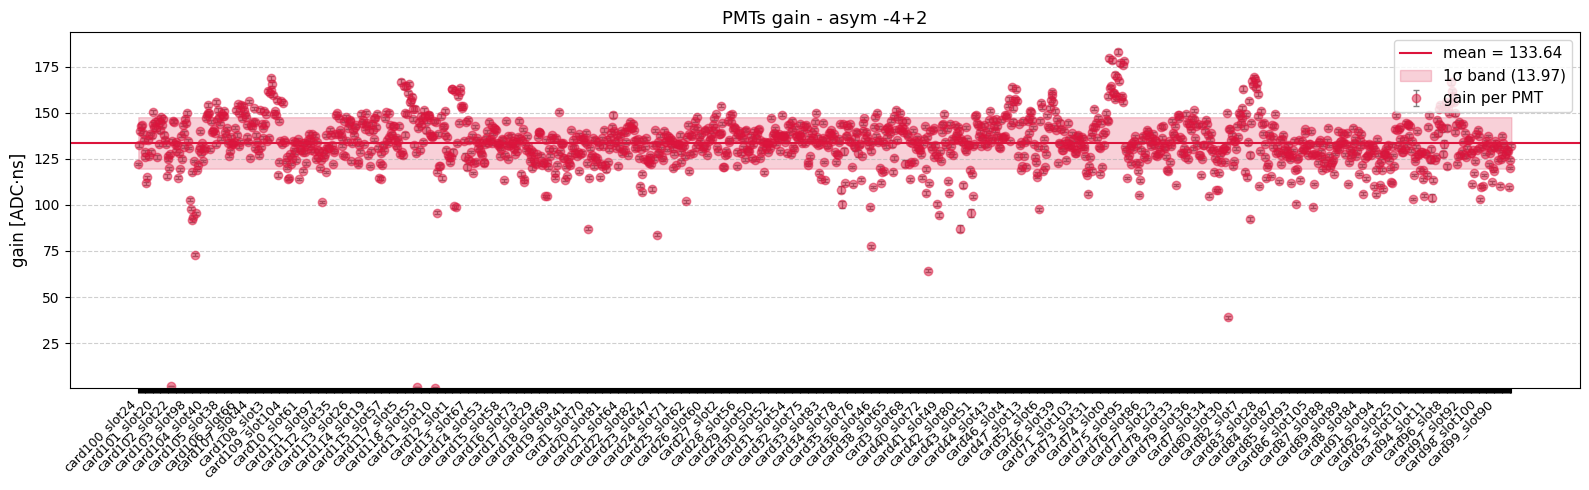

In [ ]:
file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data = np.load(file)["results"]

pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

#calculate gain + errors

gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05


fig, ax = plt.subplots(figsize=(16,5))

color = "crimson"

#scatter plot with errorbars
eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=1.0, 
    label="gain per PMT"
)

for line in eb.lines[0:1]:
    line.set_alpha(0.5)

#mean del gain and 1_sigma 
mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")

ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - asym -4+2", fontsize=13)
ax.legend(fontsize=11, loc="upper right")

plt.tight_layout()
plt.show()

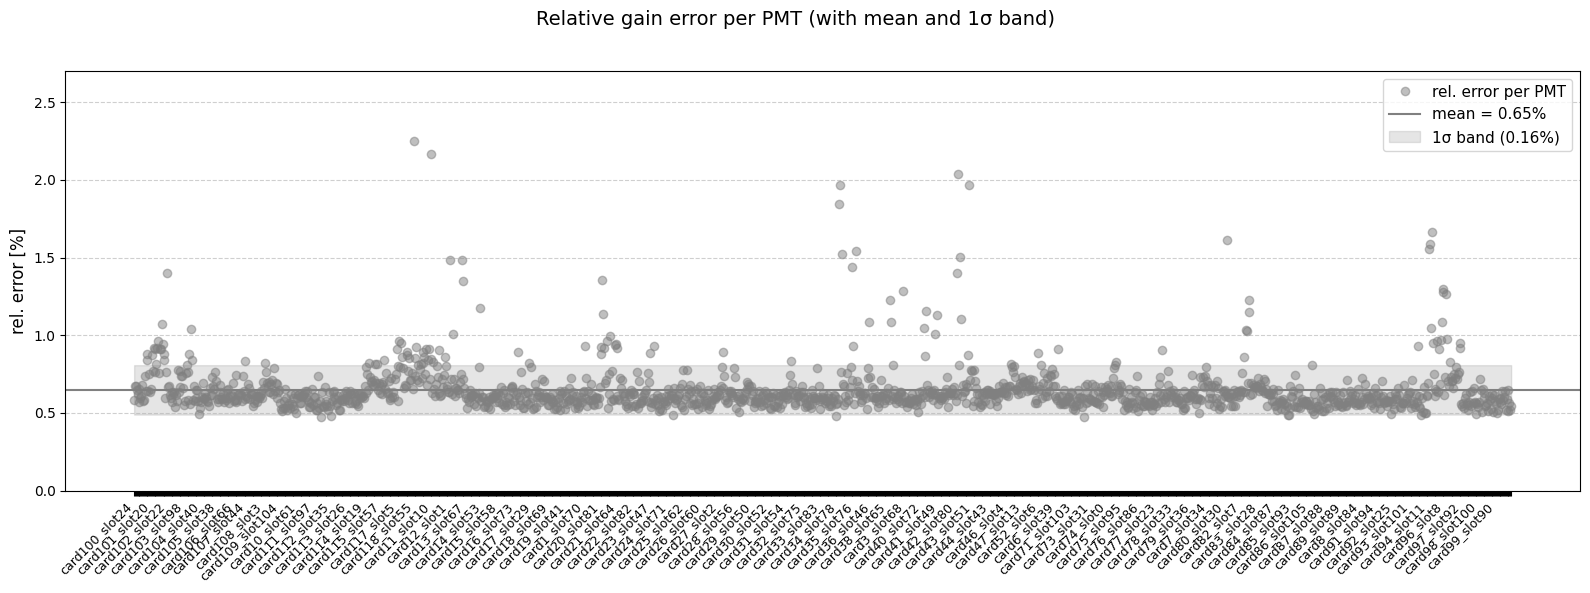

In [ ]:
#lista de archivos npz (chunks)

npz_dir = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
npz_files = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-4,1].npz" for i in range(0, n_chunks+1)]


all_results_list = []

for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

#concatenar todos los chunks en un solo array estructurado
data = np.concatenate(all_results_list)

pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (int(r["card_id"]), int(r["slot_id"]))
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))


gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

#evitar divisiones por 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 +
                      (spe_sigma/np.sqrt(N_spe))**2)

#error relativo (%)
rel_error = (gain_errors / gains) * 100.0

# --- Save result ---
#np.savez("relative_gain_errors_asym_-5+2.npz", rel_error=rel_error, x_labels=x_labels)
#print("Guardado en relative_gain_errors_asym_-5+2.npz")

fig, ax = plt.subplots(figsize=(16,6))

ax.plot(x, rel_error, 'o', color="gray", alpha=0.5, label="rel. error per PMT")

mean_rel = np.nanmean(rel_error)
std_rel  = np.nanstd(rel_error)

ax.axhline(mean_rel, color="gray", lw=1.5,
           label=f"mean = {mean_rel:.2f}%")
ax.fill_between(x, mean_rel-std_rel, mean_rel+std_rel,
                color="gray", alpha=0.2,
                label=f"1σ band ({std_rel:.2f}%)")

y_min = 0
y_max = np.nanmax(rel_error[np.isfinite(rel_error)]) * 1.2
ax.set_ylim(y_min, y_max)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(fontsize=11, loc="upper right")
ax.set_ylabel("rel. error [%]", fontsize=12)

ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

fig.suptitle("Relative gain error per PMT (with mean and 1σ band)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

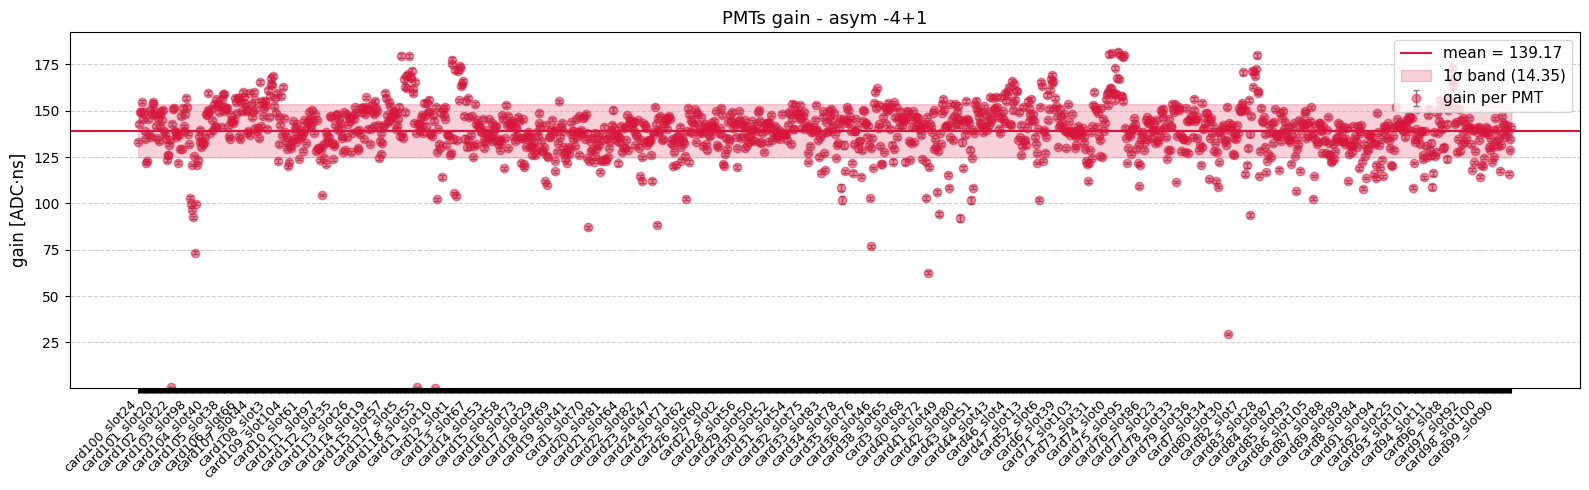

In [ ]:
npz_dir = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
npz_files = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-4,1].npz" for i in range(0, n_chunks+1)]


all_results_list = []

for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)


data = np.concatenate(all_results_list)

pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in data:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

gains = data["gain"].astype(float)
pedestal_sigma = data["pedestal_sigma"].astype(float)
spe_sigma = data["spe_sigma"].astype(float)
N_pedestal = data["N_pedestal"].astype(float)
N_spe = data["N_spe"].astype(float)

N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)


mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05


fig, ax = plt.subplots(figsize=(16,5))

color = "crimson"

eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=1.0,
    label="gain per PMT"
)

for line in eb.lines[0:1]:
    line.set_alpha(0.5)

mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")


ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - asym -4+1", fontsize=13)
ax.legend(fontsize=11, loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
for f in npz_files:
    print(f)

/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_0_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_1_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_2_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_3_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_4_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_5_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_6_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss_7_[-4,1].npz
/scratch/elena/WCTE_2025_commissioning/2

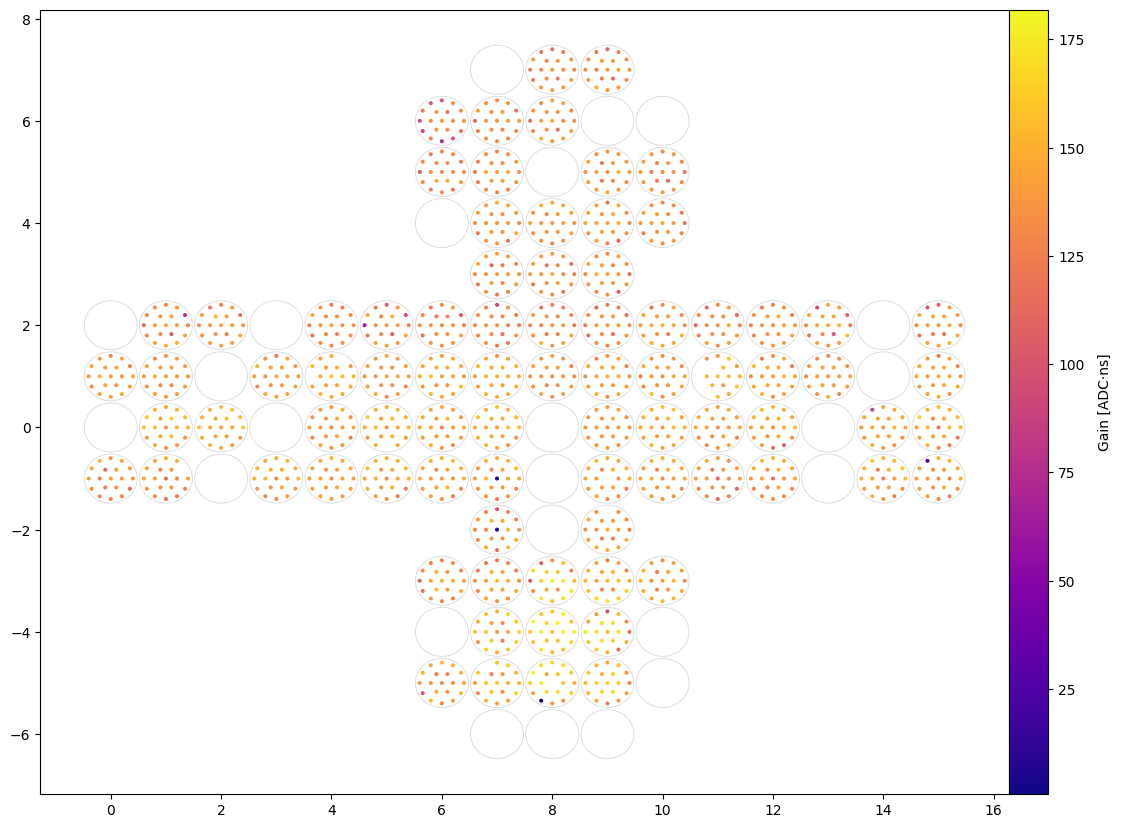

In [ ]:
#Path al repo del EventDisplay
wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

#cargar todos los chunks 
npz_dir = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
npz_files = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-4,1].npz" for i in range(0, n_chunks+1)]

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

#concatenar todos los chunks
results = np.concatenate(all_results_list)

#inicializamos EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

#creamos array de gains por canal
gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN

#llenamos gain_per_channel usando índice directo ---
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])  # channel_id en 0..18
    gain = float(entry['gain'])
    
    #mPMT_id se corresponde con 'slot' según geometría
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

#plot
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,   # colormap
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None  # estilo normal, fondo blanco
)

plt.tight_layout()
plt.show()


In [ ]:
npz_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_[-4,+2].npz"   #pmt_...s_enhanced.npz  integration_ window=16 bins
                                                                                                         #pmt_...s_enhanced_12.npz  integration_ window=12 bins
                                                                                                         #pmt_...s_enhanced_asym.npz  integration_ window=[-5,+2]]
data = np.load(npz_file)
results = data["results"]   #leemos los resultados saved en el npz


df = pd.DataFrame(results)

In [ ]:
# filtrar por card_id
#df[df['card_id'] == 29]

#mPMT específico 
#df[(df['card_id'] == 29) & (df['slot_id'] == 50)]

#filtrar por gain mayor de 100
#df[df['gain'] > 100]

#gain ascendente
#df.sort_values(by='gain', ascending=True).head(10)


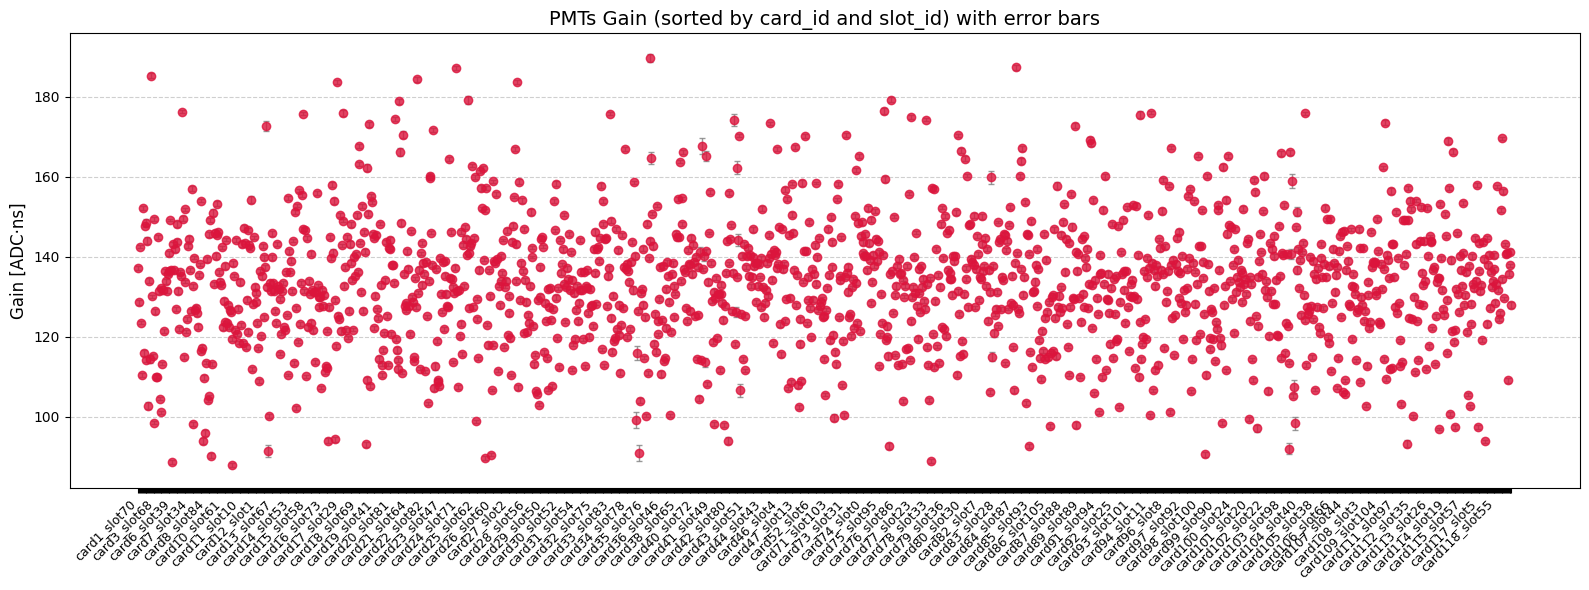

In [ ]:
df_sorted = df.sort_values(by=['card_id', 'slot_id', 'channel_id']).reset_index(drop=True)

# Index para eje x
x = np.arange(len(df_sorted))

# Ganancia y barras de error
gains = df_sorted['gain'].values
pedestal_sigma = df_sorted['pedestal_sigma'].values
spe_sigma = df_sorted['spe_sigma'].values
N_pedestal = df_sorted['N_pedestal'].values
N_spe = df_sorted['N_spe'].values

# Error de gain ya calculado (propagación de errores)
gain_errors = np.sqrt( (pedestal_sigma/np.sqrt(N_pedestal))**2 + (spe_sigma/np.sqrt(N_spe))**2 )

# Etiquetas únicas por mPMT (card+slot)
seen_mpmt = set()
xtick_labels = []
for c, s, ch in zip(df_sorted['card_id'], df_sorted['slot_id'], df_sorted['channel_id']):
    key = (c, s)
    if key not in seen_mpmt:
        xtick_labels.append(f"card{c}_slot{s}")
        seen_mpmt.add(key)
    else:
        xtick_labels.append("")

# --- Plot con barras de error ---
plt.figure(figsize=(16,6))
plt.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color='crimson', ecolor='gray',
    elinewidth=1, capsize=2, alpha=0.8
)

plt.xticks(ticks=x, labels=xtick_labels, rotation=45, ha='right', fontsize=9)
plt.ylabel("Gain [ADC·ns]", fontsize=12)
plt.title("PMTs Gain (sorted by card_id and slot_id) with error bars", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:

gains = results['gain']

mean_gain = np.nanmean(gains)
max_gain  = np.nanmax(gains)
min_gain  = np.nanmin(gains)

print(f"Gain mean: {mean_gain:.2f} ADC·ns")
print(f"Gain max: {max_gain:.2f} ADC·ns")
print(f"Gain min: {min_gain:.2f} ADC·ns")

Gain mean: 133.13 ADC·ns
Gain max: 189.75 ADC·ns
Gain min: 87.92 ADC·ns


In [ ]:
npz_file = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
data = np.load(npz_file)
results = data["results"]

#convert into df
df = pd.DataFrame(results)

#unique label per pmt
df["pmt_label"] = df.apply(lambda r: f"card{int(r['card_id'])}_slot{int(r['slot_id'])}_ch{int(r['channel_id'])}", axis=1)

#only pmts with valid gain
df_clean = df.dropna(subset=["gain"]).reset_index(drop=True)

#global statistics 
mean_gain = df_clean["gain"].mean()
std_gain = df_clean["gain"].std()
print(f"Mean gain = {mean_gain:.2f}, Std = {std_gain:.2f}")

#worst 10 (5 más bajos y 5 más altos)
df_sorted = df_clean.sort_values(by="gain", ascending=True)
worst_5_low = df_sorted.head(5)[["gain", "pmt_label"]]
worst_5_high = df_sorted.tail(5)[["gain", "pmt_label"]]
worst_10 = pd.concat([worst_5_low, worst_5_high])

#BEst 10 (closer to the mean)
df_clean["dist_from_mean"] = np.abs(df_clean["gain"] - mean_gain)
best_10 = df_clean.sort_values(by="dist_from_mean").head(10)[["gain", "pmt_label"]]

print("10 Worst PMTs")
print(worst_10.to_string(index=False))

print("10 Best PMTs")
print(best_10.to_string(index=False))


Mean gain = 133.64, Std = 13.97
10 Worst PMTs
      gain          pmt_label
  0.897823  card11_slot10_ch0
  1.151647  card117_slot5_ch9
  1.534709 card102_slot22_ch0
 38.992488 card80_slot30_ch11
 64.329364 card40_slot72_ch13
176.784342   card74_slot0_ch4
177.973424   card74_slot0_ch9
178.439589  card74_slot0_ch12
179.530937   card74_slot0_ch1
183.197415   card74_slot0_ch2
10 Best PMTs
      gain           pmt_label
133.638479   card31_slot54_ch9
133.642205   card89_slot89_ch3
133.626473  card24_slot71_ch13
133.649206   card18_slot69_ch3
133.624753  card77_slot23_ch12
133.617174  card14_slot53_ch11
133.614937  card99_slot90_ch17
133.667932 card115_slot57_ch11
133.605874   card3_slot68_ch14
133.589586   card15_slot58_ch2


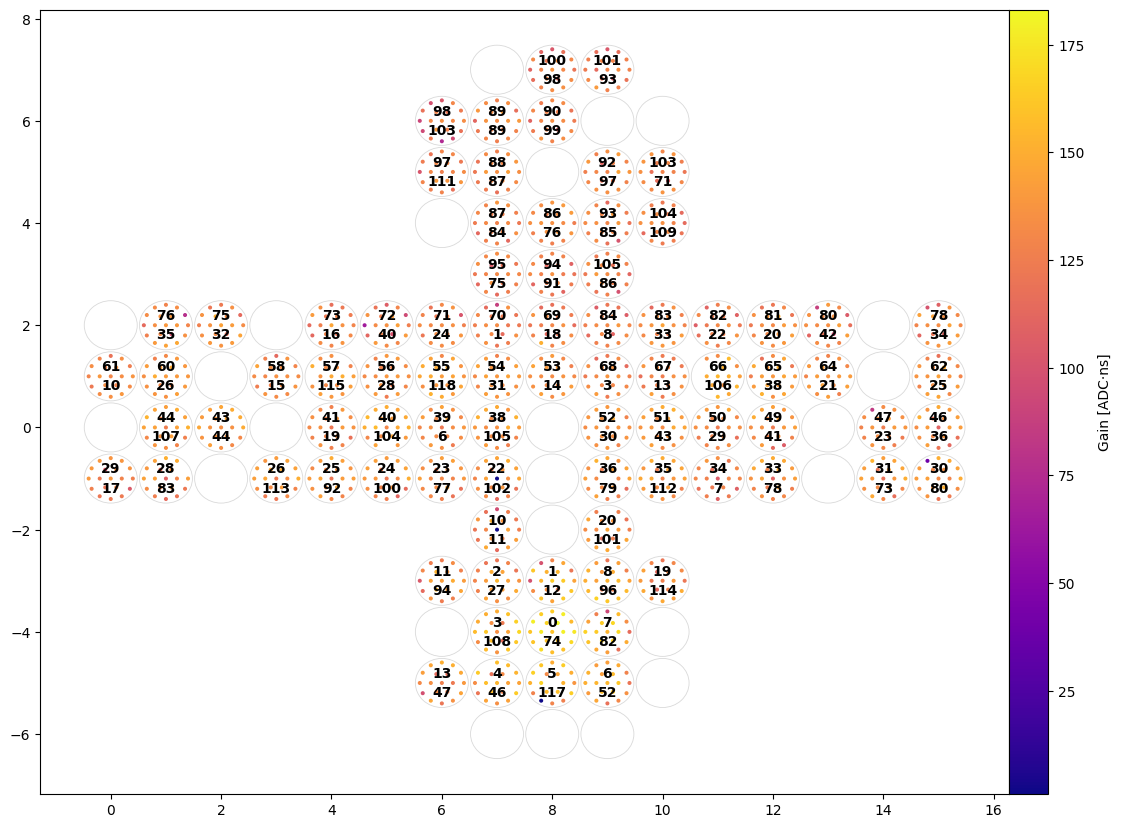

In [ ]:
# --- Archivos de resultados con path completo ---
files = {
    "asym -5+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_enhanced_asym.npz",
    "asym -4+2": "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/pmt_charge_fit_results_doubleGauss.npz"
}


results = {}
for label, file in files.items():
    data = np.load(file)["results"]
    results[label] = data


wcte_event_display_path = "/scratch/elena/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay


ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")


data_array = results["asym -4+2"]  # numpy structured array

gain_per_channel = np.full(ed.nChannels, np.nan)  # inicializamos con NaN


for i in range(len(data_array)):
    card  = data_array['card_id'][i]
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]

    # Suponemos que slot_id = índice del mPMT en la geometría
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)


for mPMT_idx, (x, y) in enumerate(ed.mPMT_2D_projection[:,1:3]):
    # Filtramos todos los canales de este mPMT
    entries = data_array[data_array['slot_id'] == mPMT_idx]
    if len(entries) == 0:
        continue
    slot_id = entries['slot_id'][0]
    card_id = entries['card_id'][0]

    plt.text(x, y + 0.05, str(slot_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='bottom')
    plt.text(x, y - 0.05, str(card_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='top')

plt.tight_layout()
plt.show()


## NEW ANALYSIS

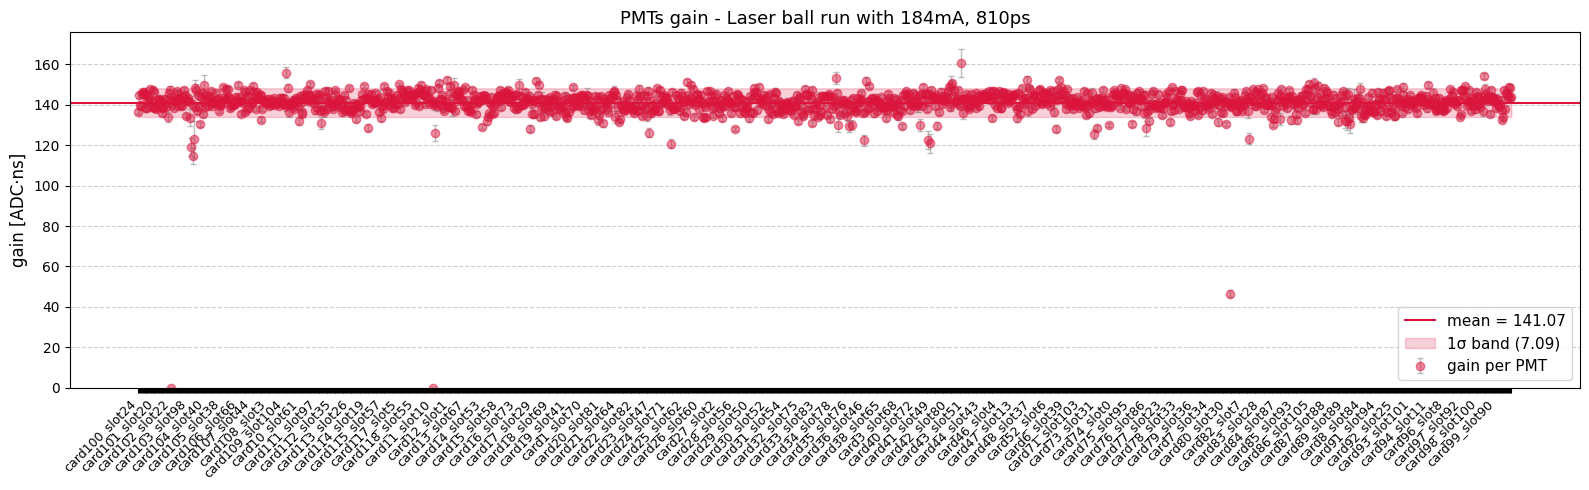

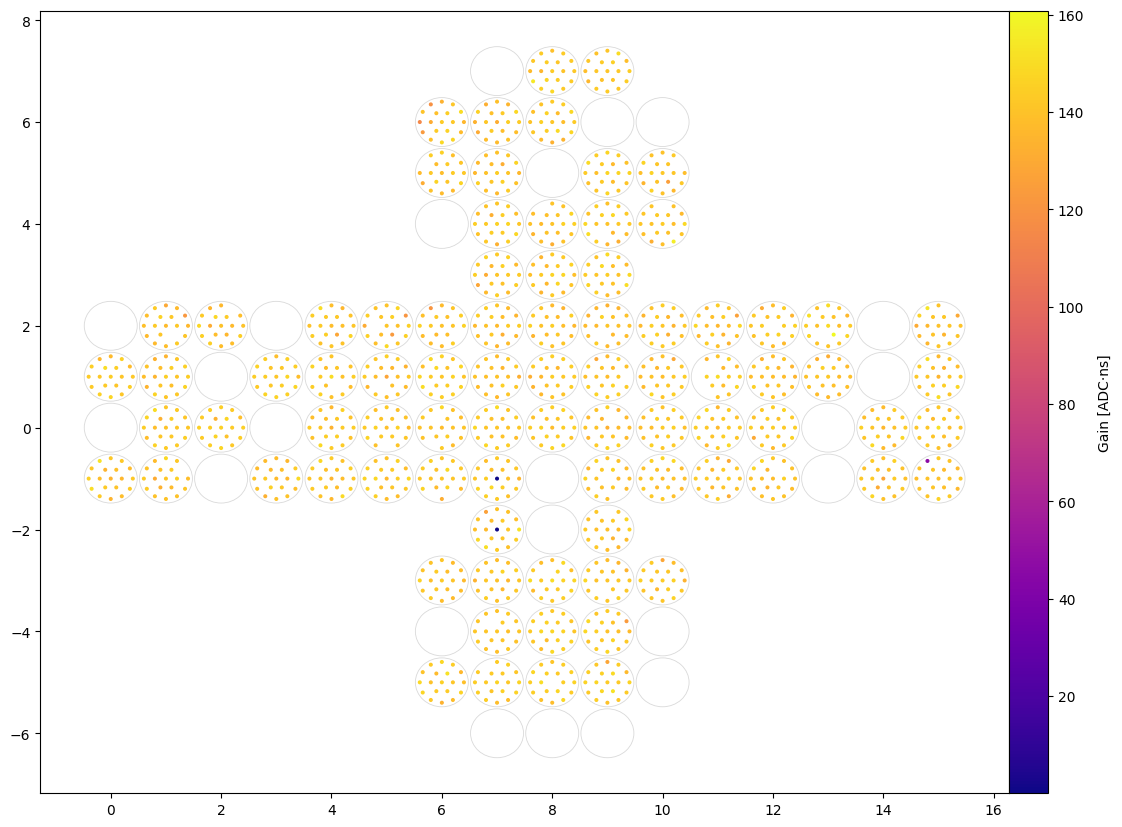

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import pandas as pd
import os
from tqdm import tqdm
import pandas as pd
import sys



#----------------- CARGAR TODOS LOS CHUNKS NUEVOS -----------------
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15  # Ajustar según número de chunks generados
#npz_files = [f"{npz_dir}NEW_doubleGauss_run2307_v3.1_chunk{i}.npz" for i in range(n_chunks+1)]
npz_files = [f"{npz_dir}twoStepfit_run2307_v2_chunk{i}.npz" for i in range(n_chunks+1)]   

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatenar todos los chunks
results = np.concatenate(all_results_list)

#----------------- PREPARAR ETIQUETAS PARA PLOTS -----------------
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

#----------------- CALCULAR GAINS Y ERRORES -----------------
gains = results["gain"].astype(float)
pedestal_sigma = results["pedestal_sigma"].astype(float)
spe_sigma = results["spe_sigma"].astype(float)
N_pedestal = results["N_pedestal"].astype(float)
N_spe = results["N_spe"].astype(float)

# Evitar divisiones por cero
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + 
                      (spe_sigma/np.sqrt(N_spe))**2)

mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05

#----------------- SCATTER PLOT GAINS -----------------
fig, ax = plt.subplots(figsize=(16,5))
color = "crimson"
marker_alpha = 0.5  # transparencia de los puntos

eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=marker_alpha,  # <-- aquí ajustamos la transparencia de los puntos
    label="gain per PMT"
)

# Mean y 1σ
mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")

ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - Laser ball run with 184mA, 810ps", fontsize=13)
ax.legend(fontsize=11, loc="lower right")

plt.tight_layout()
plt.show()

#----------------- EVENT DISPLAY -----------------
# Path al repo del EventDisplay
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# Inicializar EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# Crear array de gains por canal
gain_per_channel = np.full(ed.nChannels, np.nan)

# Llenar gain_per_channel usando índice directo
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# Plot EventDisplay
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Crear DataFrame con la info relevante
df = pd.DataFrame({
    "card_id": results["card_id"],
    "slot_id": results["slot_id"],
    "channel_id": results["channel_id"],
    "gain": gains
})

# Desviación respecto a la media
df["delta_gain"] = df["gain"] - mean_gain

# Top 10 más por encima de la media
top_high = df.nlargest(10, "delta_gain")

# Top 10 más por debajo de la media
top_low = df.nsmallest(10, "delta_gain")

print("===== Top 10 PMTs with higher gain =====")
print(top_high[["card_id","slot_id","channel_id","gain"]].to_string(index=False))

print("\n===== Top 10 PMTs with lowest gain =====")
print(top_low[["card_id","slot_id","channel_id","gain"]].to_string(index=False))

===== Top 10 PMTs with higher gain =====
 card_id  slot_id  channel_id       gain
      42       80           6 160.725163
     109      104          11 155.901348
      98      100          14 154.327461
      34       78          11 153.214227
      52        6           3 152.277951
      47       13           5 152.162561
      11       10           7 152.153965
      17       29          11 151.978356
      36       46           0 151.935421
      25       62          11 151.295316

===== Top 10 PMTs with lowest gain =====
 card_id  slot_id  channel_id       gain
     102       22           0   0.000023
      11       10           0   0.000100
      80       30          11  46.437760
     103       98          13 114.695581
     103       98          11 119.226782
      24       71          11 120.635567
      40       72           8 121.008722
      35       76           8 122.422039
      40       72           6 122.436226
     103       98          14 122.853383


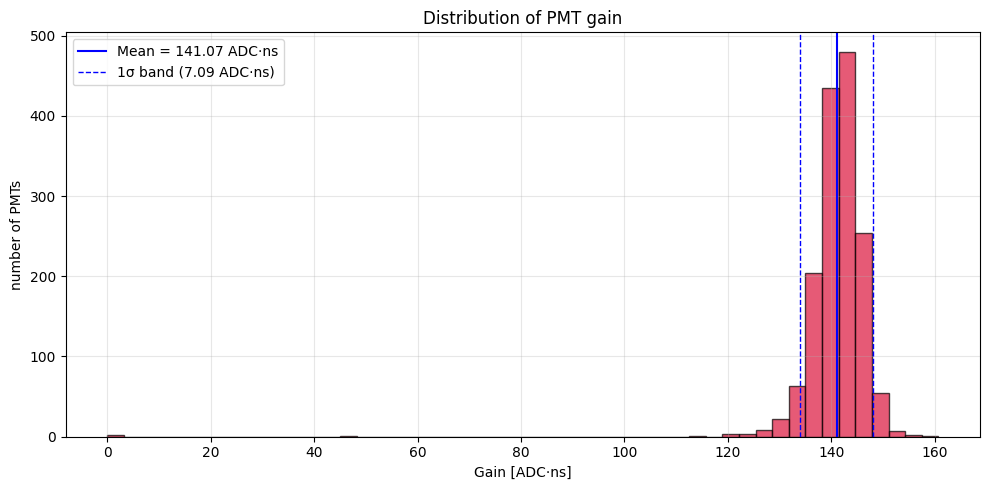

NameError: name 'norm' is not defined

In [3]:
plt.figure(figsize=(10,5))
plt.hist(gains[mask], bins=50, color='crimson', alpha=0.7, edgecolor='black')
plt.axvline(mean_gain, color='blue', lw=1.5, label=f"Mean = {mean_gain:.2f} ADC·ns")
plt.axvline(mean_gain - std_gain, color='blue', lw=1, ls='--', label=f"1σ band ({std_gain:.2f} ADC·ns)")
plt.axvline(mean_gain + std_gain, color='blue', lw=1, ls='--')
plt.xlabel("Gain [ADC·ns]")
plt.ylabel("number of PMTs")
plt.title("Distribution of PMT gain")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Assume gains[mask] contains your data
data = gains[mask]

# Fit a Gaussian (returns mean and std)
mu_fit, sigma_fit = norm.fit(data)

# Histogram
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(data, bins=50, color='crimson', alpha=0.7, edgecolor='black', density=True)

# Plot Gaussian fit
x = np.linspace(bins[0], bins[-1], 1000)
plt.plot(x, norm.pdf(x, mu_fit, sigma_fit), 'b-', lw=2, label=f"Gaussian fit\nμ={mu_fit:.2f}, σ={sigma_fit:.2f}")

# Plot mean ± 1σ from the fit
plt.axvline(mu_fit, color='blue', lw=1.5, label=f"Fit μ = {mu_fit:.2f}")
plt.axvline(mu_fit - sigma_fit, color='blue', lw=1, ls='--', label=f"Fit σ = {sigma_fit:.2f}")
plt.axvline(mu_fit + sigma_fit, color='blue', lw=1, ls='--')

plt.xlabel("Gain [ADC·ns]")
plt.ylabel("Density")
plt.title("Distribution of PMT gain with Gaussian fit")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

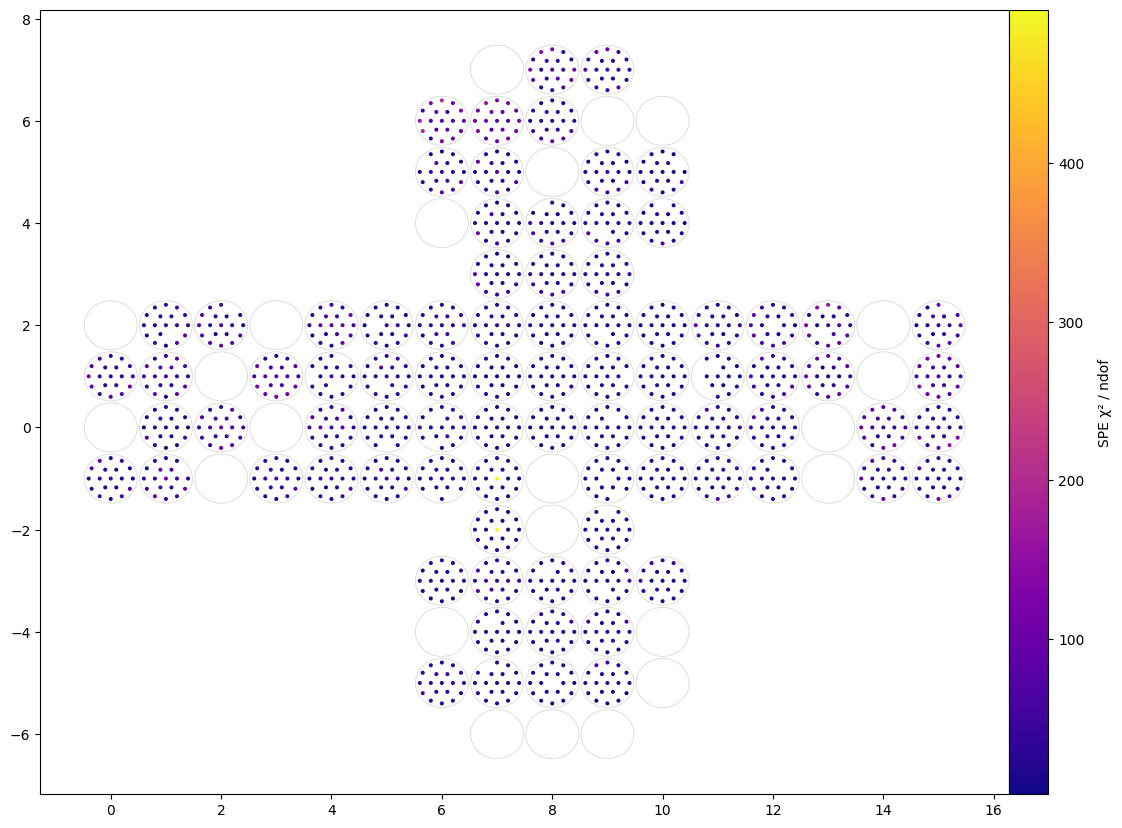

In [4]:
chi2ndof_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    chi2 = float(entry['spe_chi2'])
    ndof = float(entry['spe_chi2_ndof'])
    if ndof > 0:  # evita división por cero
        chi2ndof = chi2 / ndof
    else:
        chi2ndof = np.nan
    idx = 19 * slot + ch
    if idx < ed.nChannels:
        chi2ndof_per_channel[idx] = chi2ndof

# Plot EventDisplay del χ²/ndof
ed.plotEventDisplay(
    data=chi2ndof_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(chi2ndof_per_channel), vmax=np.nanmax(chi2ndof_per_channel)),
    color_label="SPE χ² / ndof",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.tight_layout()
plt.show()

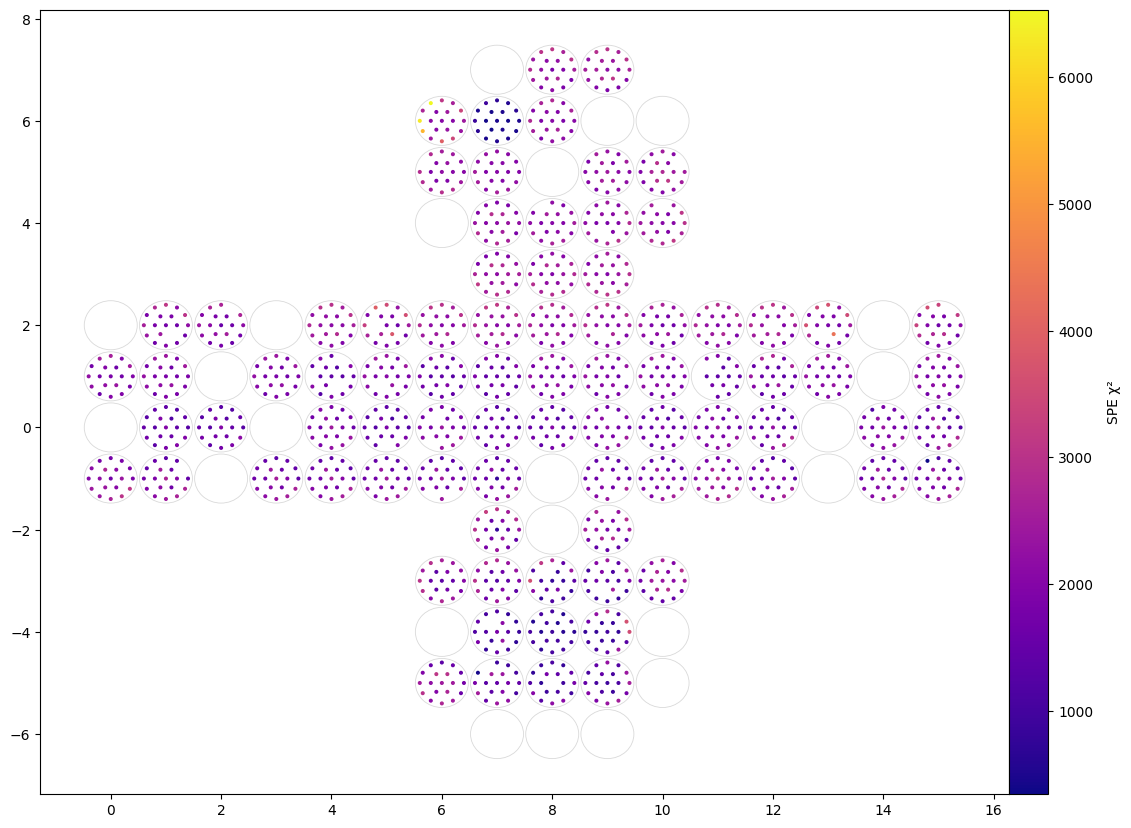

In [6]:

from scipy.stats import norm

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

results = np.concatenate(all_results_list)

# ----------------- Recalculate χ² per PMT -----------------
chi2_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch = int(entry['channel_id'])

    mu2 = float(entry['spe_mean'])
    sigma2 = float(entry['spe_sigma'])
    w = entry['N_pedestal'] / (entry['N_pedestal'] + entry['N_spe'])

    # Reconstruct charges using histogram from fit
    n_spe = int(entry['N_spe'])
    if n_spe < 5:
        continue  # skip PMTs with too few SPE points

    # Generate pseudo-charge distribution from mu2/sigma2 for χ² calculation
    # Here we approximate: in practice, if raw charges are stored, we can use them directly
    # We'll use the SPE mask approach as in notebook
    charges = np.linspace(mu2 - 4*sigma2, mu2 + 4*sigma2, n_spe)
    spe_mask = (charges > mu2 - 1.5*sigma2) & (charges < mu2 + 1.5*sigma2)
    x_spe = charges[spe_mask]
    if len(x_spe) < 5:
        continue

    bins = np.linspace(x_spe.min(), x_spe.max(), 50)
    hist_counts, bin_edges = np.histogram(x_spe, bins=bins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]

    expected_counts = (1 - w) * norm.pdf(bin_centers, mu2, sigma2) * len(charges) * bin_width
    expected_counts = np.clip(expected_counts, 1e-6, None)
    chi2 = np.sum((hist_counts - expected_counts)**2 / expected_counts)

    idx = 19 * slot + ch
    if idx < ed.nChannels:
        chi2_per_channel[idx] = chi2

# ----------------- Plot χ² with EventDisplay -----------------
ed.plotEventDisplay(
    data=chi2_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(chi2_per_channel), vmax=np.nanmax(chi2_per_channel)),
    color_label="SPE χ²",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.tight_layout()
plt.show()

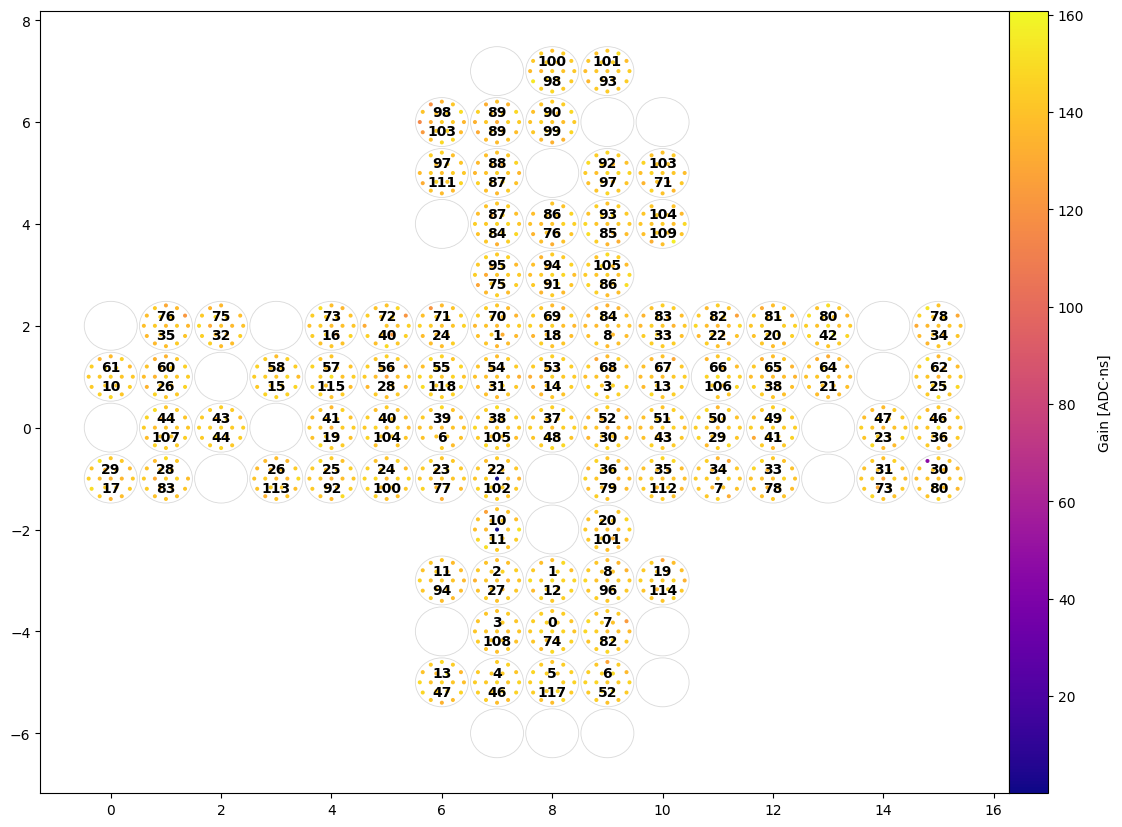

In [7]:
#----------------- LOAD ALL CHUNKS -----------------

npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15  # Adjust based on total number of chunks generated
#npz_files = [f"{npz_dir}NEW_doubleGauss_run2307_v3_chunk{i}.npz" for i in range(n_chunks+1)]
npz_files = [f"{npz_dir}twoStepfit_run2307_v2_chunk{i}.npz" for i in range(n_chunks+1)] 

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatenate all chunks
results = np.concatenate(all_results_list)

#----------------- COMPUTE GAINS AND ERRORS -----------------
gains = results["gain"].astype(float)
pedestal_sigma = results["pedestal_sigma"].astype(float)
spe_sigma = results["spe_sigma"].astype(float)
N_pedestal = results["N_pedestal"].astype(float)
N_spe = results["N_spe"].astype(float)

# Avoid division by zero
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 +
                      (spe_sigma/np.sqrt(N_spe))**2)

#----------------- EVENT DISPLAY -----------------
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

# Initialize EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# Create array of gains per channel
gain_per_channel = np.full(ed.nChannels, np.nan)

# Fill gain_per_channel
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

#----------------- PLOT EVENT DISPLAY -----------------
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel),
                                vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

#----------------- ADD SLOT AND CARD LABELS -----------------
for mPMT_idx, (x, y) in enumerate(ed.mPMT_2D_projection[:, 1:3]):
    # Filter all channels of this mPMT
    entries = results[results['slot_id'] == mPMT_idx]
    if len(entries) == 0:
        continue
    slot_id = entries['slot_id'][0]
    card_id = entries['card_id'][0]

    # Plot slot and card IDs above and below each mPMT position
    plt.text(x, y + 0.05, str(slot_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='bottom')
    plt.text(x, y - 0.05, str(card_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='top')

plt.tight_layout()
plt.show()

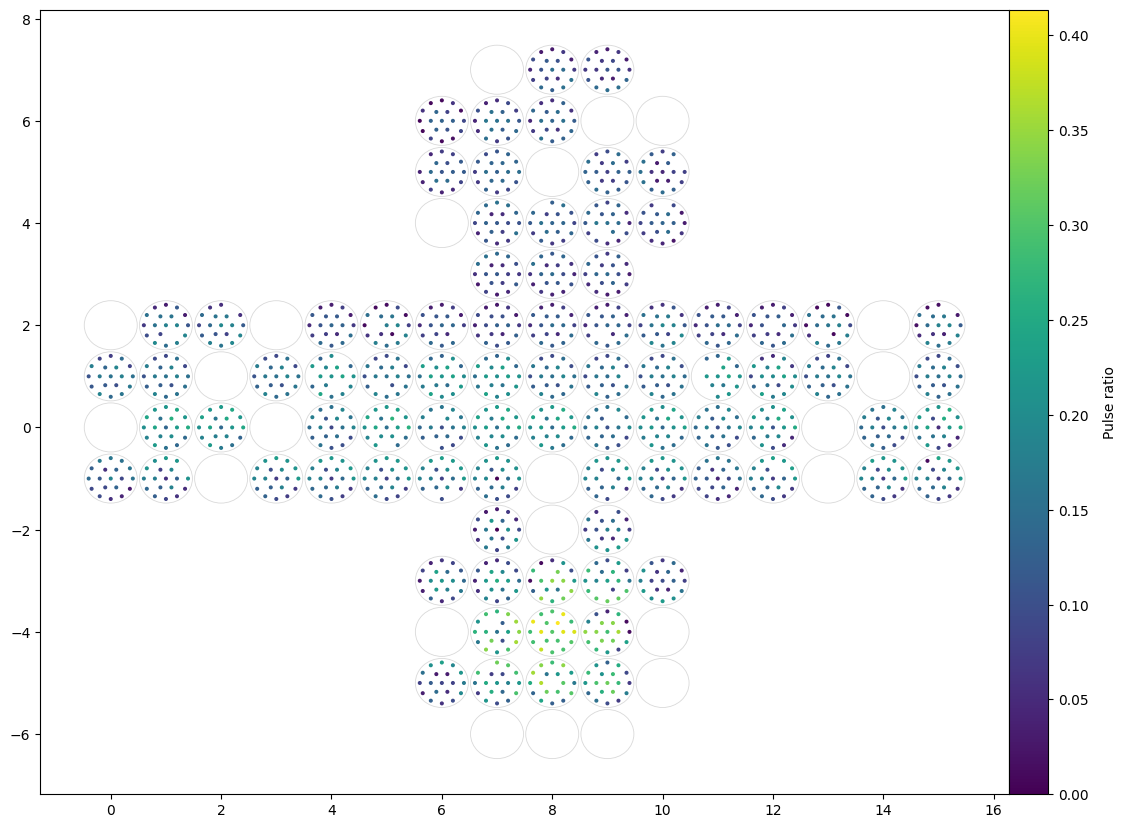

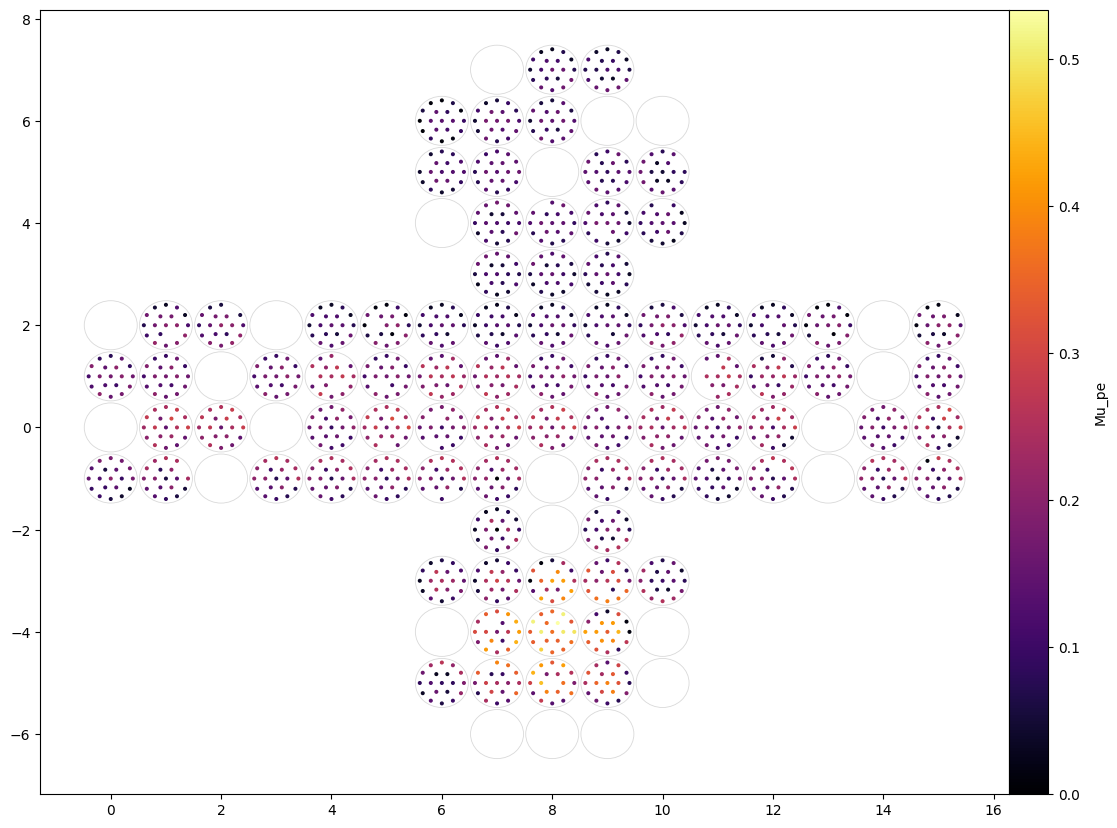

In [8]:
# ---------------------------
# EVENT DISPLAY: pulse_ratio
# ---------------------------
pulse_ratio_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    pulse_ratio = float(entry['pulse_ratio'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        pulse_ratio_per_channel[idx] = pulse_ratio

ed.plotEventDisplay(
    data=pulse_ratio_per_channel,
    color_map=plt.cm.viridis,
    color_norm=colors.Normalize(vmin=0, vmax=np.nanmax(pulse_ratio_per_channel)),
    color_label="Pulse ratio",
    fig_width=12,
    show_zero=True,
    style=None
)
plt.tight_layout()
plt.show()


# ---------------------------
# EVENT DISPLAY: mu_pe
# ---------------------------
mu_pe_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    mu_pe = float(entry['mu_pe'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        mu_pe_per_channel[idx] = mu_pe

ed.plotEventDisplay(
    data=mu_pe_per_channel,
    color_map=plt.cm.inferno,
    color_norm=colors.Normalize(vmin=0, vmax=np.nanmax(mu_pe_per_channel)),
    color_label="Mu_pe",
    fig_width=12,
    show_zero=True,
    style=None
)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np

# Crear listas para tabla
table_data = []

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    pulse_ratio = float(entry['pulse_ratio'])
    mu_pe = float(entry['mu_pe'])
    
    table_data.append({
        "Card": card,
        "Slot": slot,
        "Channel": ch,
        "Pulse_ratio": pulse_ratio,
        "Mu_pe": mu_pe
    })

# Convertir a DataFrame
df = pd.DataFrame(table_data)

# Ordenar por pulse_ratio y mu_pe (ascendente)
df_sorted_pulse = df.sort_values("Pulse_ratio", ascending=True).reset_index(drop=True)
df_sorted_mu_pe = df.sort_values("Mu_pe", ascending=True).reset_index(drop=True)

# Mostrar top 10 PMTs con valores más bajos
print("=== PMTs with lowest pulse_ratio ===")
print(df_sorted_pulse.head(10))

print("\n=== PMTs with lowest mu_pe ===")
print(df_sorted_mu_pe.head(10))

=== PMTs with lowest pulse_ratio ===
   Card  Slot  Channel  Pulse_ratio     Mu_pe
0    11    10        0     0.000000 -0.000000
1   102    22        0     0.000000 -0.000000
2   103    98       13     0.005792  0.005809
3   103    98       14     0.006523  0.006544
4   103    98       11     0.008435  0.008470
5   103    98       16     0.009166  0.009208
6    42    80        6     0.009615  0.009662
7   103    98       10     0.009953  0.010003
8    42    80       11     0.010346  0.010400
9    42    80       10     0.010403  0.010457

=== PMTs with lowest mu_pe ===
   Card  Slot  Channel  Pulse_ratio     Mu_pe
0    11    10        0     0.000000 -0.000000
1   102    22        0     0.000000 -0.000000
2   103    98       13     0.005792  0.005809
3   103    98       14     0.006523  0.006544
4   103    98       11     0.008435  0.008470
5   103    98       16     0.009166  0.009208
6    42    80        6     0.009615  0.009662
7   103    98       10     0.009953  0.010003
8    42    

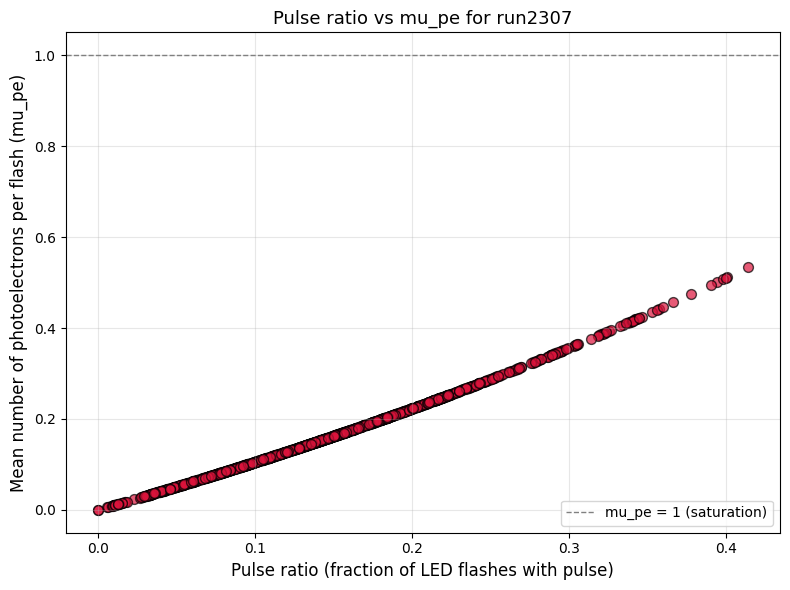

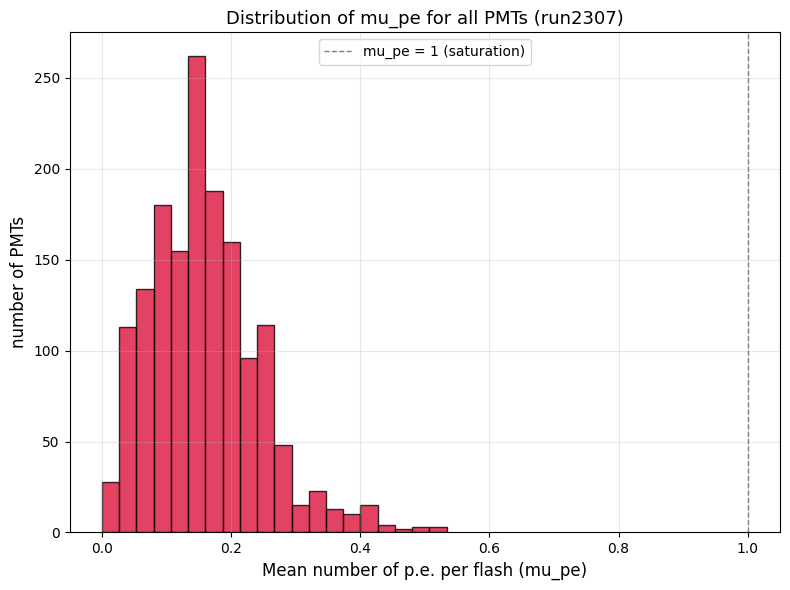

Min mu_pe: -0.000, Max mu_pe: 0.534
Mean mu_pe: 0.159, Median mu_pe: 0.152


In [10]:
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15  # Ajusta según número de chunks generados
npz_files = [f"{npz_dir}NEW_doubleGauss_run2307_v3_chunk{i}.npz" for i in range(n_chunks+1)]

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

results = np.concatenate(all_results_list)


pulse_ratios = results["pulse_ratio"].astype(float)
mu_pes = results["mu_pe"].astype(float)


plt.figure(figsize=(8,6))
plt.scatter(pulse_ratios, mu_pes, c='crimson', alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Pulse ratio (fraction of LED flashes with pulse)", fontsize=12)
plt.ylabel("Mean number of photoelectrons per flash (mu_pe)", fontsize=12)
plt.title("Pulse ratio vs mu_pe for run2307", fontsize=13)
plt.grid(True, alpha=0.3)
plt.axhline(1.0, color='gray', linestyle='--', lw=1, label="mu_pe = 1 (saturation)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(mu_pes, bins=20, color='crimson', alpha=0.8, edgecolor='k')
plt.xlabel("Mean number of p.e. per flash (mu_pe)", fontsize=12)
plt.ylabel("number of PMTs", fontsize=12)
plt.title("Distribution of mu_pe for all PMTs (run2307)", fontsize=13)
plt.axvline(1.0, color='gray', linestyle='--', lw=1, label="mu_pe = 1 (saturation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Opcional: imprimir rango
print(f"Min mu_pe: {np.min(mu_pes):.3f}, Max mu_pe: {np.max(mu_pes):.3f}")
print(f"Mean mu_pe: {np.mean(mu_pes):.3f}, Median mu_pe: {np.median(mu_pes):.3f}")

In [6]:
# Path a los waveforms
signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2307"

# Inicializamos array para todos los channels
pulse_ratio_per_channel = np.full(ed.nChannels, np.nan)

# Umbral para pulse finding
def do_pulse_finding(wf, threshold):
    return np.where(wf > threshold)[0]

print("Calculando pulse ratios por LED flash...")

for i, entry in enumerate(tqdm(results, desc="PMTs processed")):
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    mu_ped = float(entry['pedestal_mean'])
    mu_spe = float(entry['spe_mean'])

    # cargar waveforms
    pmt_label = f"card{card}_slot{slot}_ch{ch}"
    npz_file = os.path.join(signal_dir, pmt_label + ".npz")
    if not os.path.isfile(npz_file):
        print(f"⚠ Waveform file not found: {npz_file}")
        continue
    waveforms = np.load(npz_file)["waveforms"]

    # calcular cargas pre/post alrededor del máximo
    charges = np.array([np.sum(wf[np.argmax(wf)-5 : np.argmax(wf)+3]) for wf in waveforms])
    
    # threshold basado en pedestal + 50% de SPE
    threshold = 10  # ADC·ns
    pulse_ratio = np.sum(charges > threshold) / len(charges)

    # asignar al channel correcto
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        pulse_ratio_per_channel[idx] = pulse_ratio

    # print de control cada 100 PMTs
    if (i+1) % 100 == 0:
        print(f"Processed {i+1} PMTs, last pulse_ratio = {pulse_ratio:.3f}")

Calculando pulse ratios por LED flash...


PMTs processed:   0%|                                                                                                                          | 0/1567 [00:00<?, ?it/s]

PMTs processed:   6%|███████▏                                                                                                        | 100/1567 [00:40<11:14,  2.18it/s]

Processed 100 PMTs, last pulse_ratio = 0.198


PMTs processed:  13%|██████████████▎                                                                                                 | 200/1567 [01:20<10:19,  2.21it/s]

Processed 200 PMTs, last pulse_ratio = 0.162


PMTs processed:  19%|█████████████████████▍                                                                                          | 300/1567 [02:00<09:33,  2.21it/s]

Processed 300 PMTs, last pulse_ratio = 0.325


PMTs processed:  26%|████████████████████████████▌                                                                                   | 400/1567 [02:39<07:44,  2.51it/s]

Processed 400 PMTs, last pulse_ratio = 0.155


PMTs processed:  32%|███████████████████████████████████▋                                                                            | 500/1567 [03:17<06:37,  2.68it/s]

Processed 500 PMTs, last pulse_ratio = 0.192


PMTs processed:  38%|██████████████████████████████████████████▉                                                                     | 600/1567 [03:55<05:57,  2.71it/s]

Processed 600 PMTs, last pulse_ratio = 0.198


PMTs processed:  45%|██████████████████████████████████████████████████                                                              | 700/1567 [04:35<05:48,  2.49it/s]

Processed 700 PMTs, last pulse_ratio = 0.191


PMTs processed:  51%|█████████████████████████████████████████████████████████▏                                                      | 800/1567 [05:14<04:51,  2.63it/s]

Processed 800 PMTs, last pulse_ratio = 0.185


PMTs processed:  57%|████████████████████████████████████████████████████████████████▎                                               | 900/1567 [05:51<04:03,  2.74it/s]

Processed 900 PMTs, last pulse_ratio = 0.064


PMTs processed:  64%|██████████████████████████████████████████████████████████████████████▊                                        | 1000/1567 [06:29<03:22,  2.80it/s]

Processed 1000 PMTs, last pulse_ratio = 0.132


PMTs processed:  70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1100/1567 [07:08<03:05,  2.52it/s]

Processed 1100 PMTs, last pulse_ratio = 0.145


PMTs processed:  77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1200/1567 [07:45<02:13,  2.75it/s]

Processed 1200 PMTs, last pulse_ratio = 0.209


PMTs processed:  83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1300/1567 [08:24<01:34,  2.82it/s]

Processed 1300 PMTs, last pulse_ratio = 0.230


PMTs processed:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1400/1567 [08:56<00:42,  3.91it/s]

Processed 1400 PMTs, last pulse_ratio = 0.042


PMTs processed:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1500/1567 [09:34<00:25,  2.64it/s]

Processed 1500 PMTs, last pulse_ratio = 0.344


PMTs processed: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [10:00<00:00,  2.61it/s]


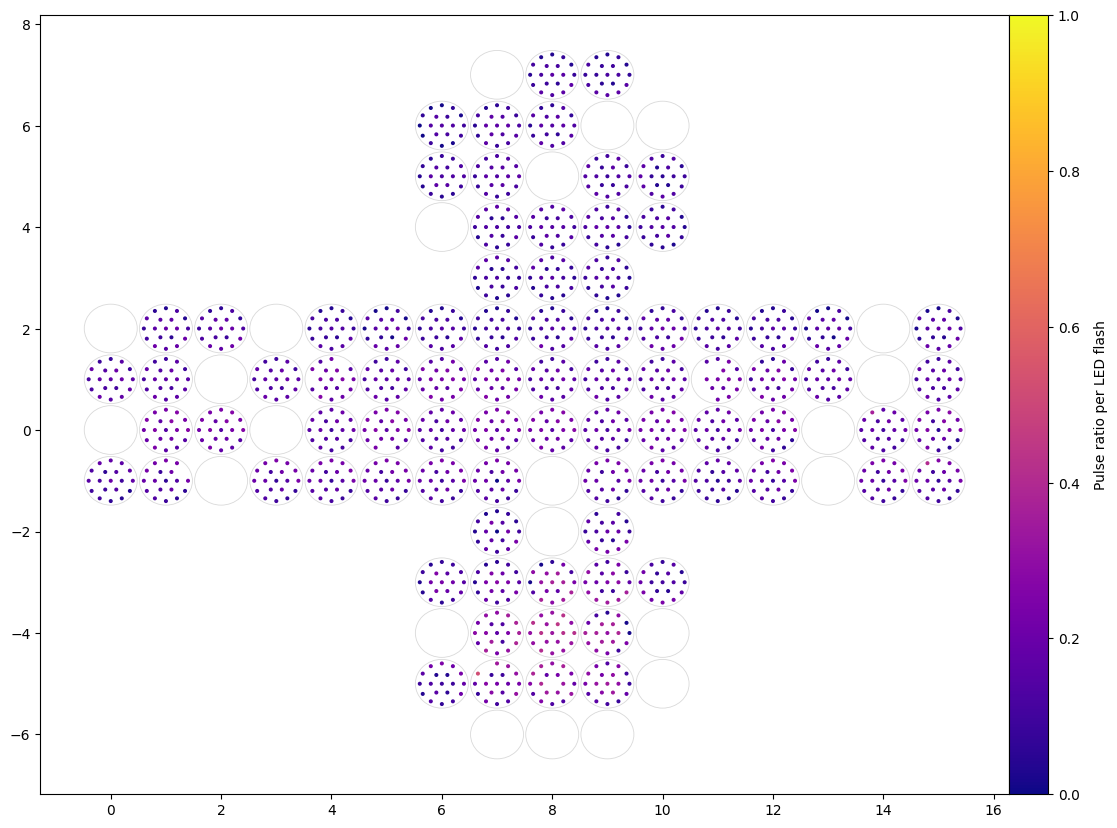

In [7]:
ed.plotEventDisplay(
    data=pulse_ratio_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=0.0, vmax=1),  # rango fijo
    color_label="Pulse ratio per LED flash",
    fig_width=12,
    show_zero=True,
    style=None
)
plt.tight_layout()
plt.show()

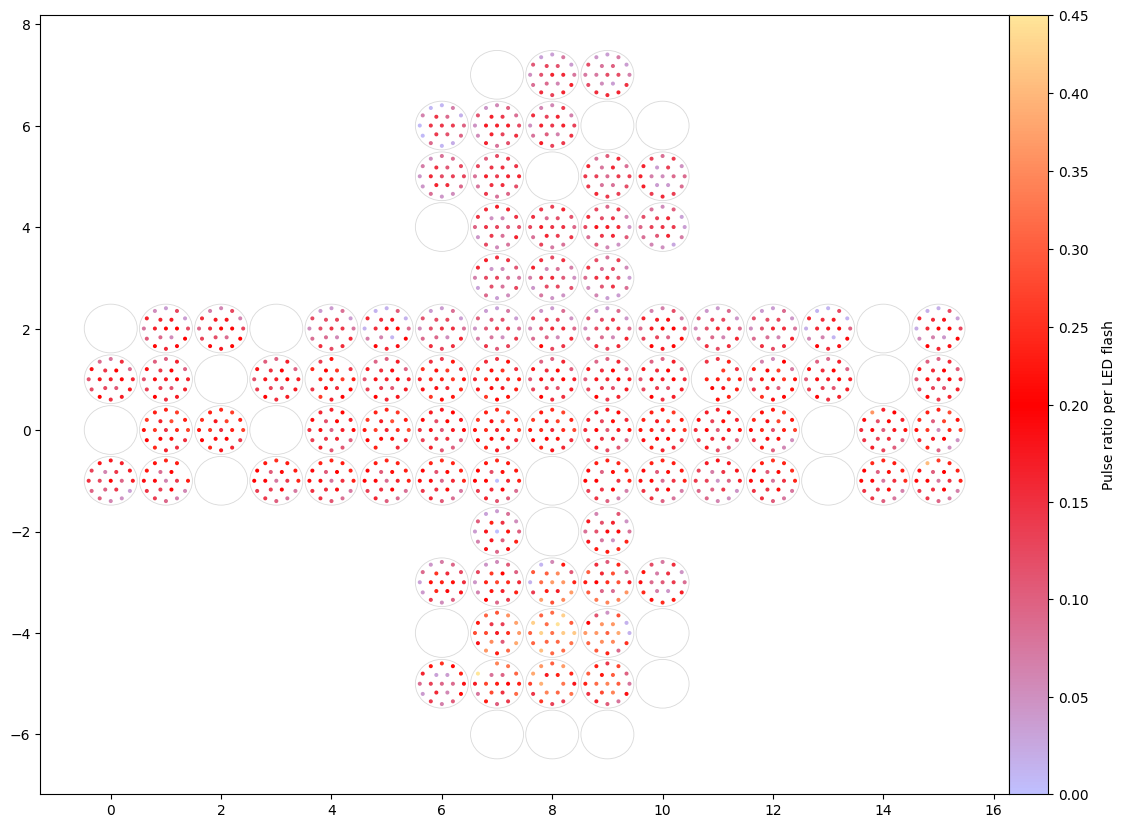

In [8]:
import matplotlib.colors as mcolors

vmin, vmax = 0.0, 0.45
highlight_value = 0.20

# Basado en plasma, pero con tonos más suaves excepto el rojo central
colors_list = [
    (0.75, 0.75, 1.0),   # azul/lila claro para valores bajos
    (1.0, 0.0, 0.0),     # rojo intenso en el valor esperado
    (1.0, 0.9, 0.6)      # amarillo claro para valores altos
]

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "soft_plasma_red_center", colors_list, N=256
)

# Centramos en 0.20 (valor esperado)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=highlight_value, vmax=vmax)

# Plot EventDisplay
ed.plotEventDisplay(
    data=pulse_ratio_per_channel,
    color_map=custom_cmap,
    color_norm=norm,
    color_label="Pulse ratio per LED flash",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.tight_layout()
plt.show()


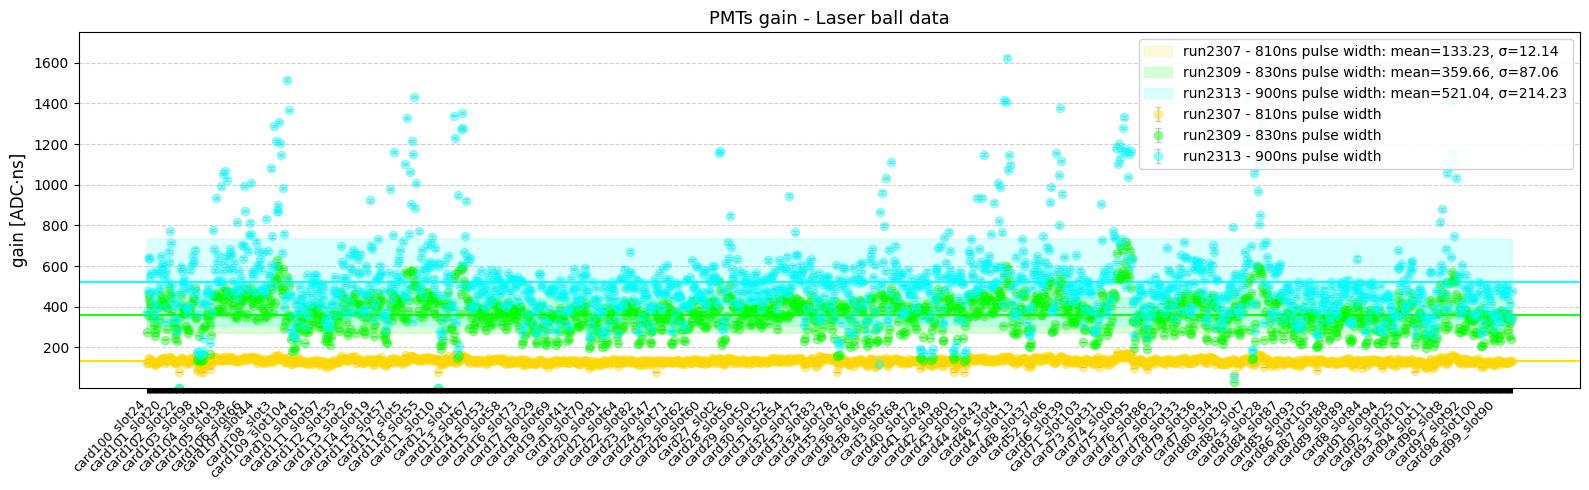

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import pandas as pd

#----------------- CONFIGURACIÓN -----------------
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15 

runs = {
    "run2307 - 810ns pulse width": "NEW_doubleGauss_",          # <-- sin 'run2307_' !
    "run2309 - 830ns pulse width": "NEW_doubleGauss_run2309_",
    "run2313 - 900ns pulse width": "NEW_doubleGauss_run2313_"
}

colors_dict = {
    "run2307 - 810ns pulse width": "gold",
    "run2309 - 830ns pulse width": "lime",
    "run2313 - 900ns pulse width": "cyan"
}

#----------------- FUNCIÓN PARA CARGAR DATOS -----------------
def load_results(run_prefix):
    npz_files = [f"{npz_dir}{run_prefix}{i}.npz" for i in range(n_chunks+1)]
    all_chunks = []
    for f in npz_files:
        data_chunk = np.load(f)["results"]
        all_chunks.append(data_chunk)
    return np.concatenate(all_chunks)

#----------------- CARGAR LOS TRES DATASETS -----------------
results_dict = {label: load_results(prefix) for label, prefix in runs.items()}

#----------------- PREPARAR EJE X Y ETIQUETAS -----------------
# Usamos el primer dataset como referencia
ref_results = next(iter(results_dict.values()))
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in ref_results:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")
x = np.arange(len(pmt_labels))

#----------------- PLOT COMPARATIVO -----------------
fig, ax = plt.subplots(figsize=(16,5))

for label, results in results_dict.items():
    gains = results["gain"].astype(float)
    pedestal_sigma = results["pedestal_sigma"].astype(float)
    spe_sigma = results["spe_sigma"].astype(float)
    N_pedestal = results["N_pedestal"].astype(float)
    N_spe = results["N_spe"].astype(float)
    
    # Evitar divisiones por cero
    N_pedestal[N_pedestal == 0] = np.nan
    N_spe[N_spe == 0] = np.nan

    gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 +
                          (spe_sigma/np.sqrt(N_spe))**2)

    mask = np.isfinite(gains) & np.isfinite(gain_errors)

    color = colors_dict[label]
    marker_alpha = 0.4  # puntos translúcidos

    # --- Scatter plot con barras de error ---
    ax.errorbar(
        x, gains, yerr=gain_errors,
        fmt='o', color=color, ecolor='gray',
        elinewidth=1, capsize=2,
        alpha=marker_alpha,
        label=label
    )

    # --- Media y 1σ ---
    mean_gain = np.nanmean(gains)
    std_gain = np.nanstd(gains)

    ax.axhline(mean_gain, color=color, lw=1.5, alpha=0.9)
    ax.fill_between(
        x, mean_gain - std_gain, mean_gain + std_gain,
        color=color, alpha=0.15,
        label=f"{label}: mean={mean_gain:.2f}, σ={std_gain:.2f}"
    )

#----------------- ESCALAS, LEYENDAS Y FORMATO -----------------
all_gains = np.concatenate([res["gain"].astype(float) for res in results_dict.values()])
y_min = np.nanmin(all_gains) * 0.95
y_max = np.nanmax(all_gains) * 1.05

ax.set_ylim(y_min, 1750)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]", fontsize=12)
ax.set_title("PMTs gain - Laser ball data", fontsize=13)
ax.legend(fontsize=10, loc="upper right", framealpha=0.9)

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#----------------- CONFIGURACIÓN -----------------
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15 

runs = {
    "run2307 - 810ns pulse width": "NEW_doubleGauss_",
    #"run2309 - 830ns pulse width": "NEW_doubleGauss_run2309_",
    #"run2313 - 900ns pulse width": "NEW_doubleGauss_run2313_"
}

colors_dict = {
    "run2307 - 810ns pulse width": "gold",
    "run2309 - 830ns pulse width": "lime",
    "run2313 - 900ns pulse width": "cyan"
}

#----------------- FUNCIÓN PARA CARGAR DATOS -----------------
def load_results(run_prefix):
    npz_files = [f"{npz_dir}{run_prefix}{i}.npz" for i in range(n_chunks+1)]
    all_chunks = []
    for f in npz_files:
        data_chunk = np.load(f)["results"]
        all_chunks.append(data_chunk)
    return np.concatenate(all_chunks)

#----------------- CARGAR LOS TRES DATASETS -----------------
results_dict = {label: load_results(prefix) for label, prefix in runs.items()}

#----------------- CÁLCULO DE DESVIACIONES -----------------
top_outliers = []

for label, results in results_dict.items():
    gains = results["gain"].astype(float)
    mean_gain = np.nanmean(gains)
    std_gain = np.nanstd(gains)
    
    # z-score = (gain - mean)/std
    z_scores = (gains - mean_gain) / std_gain
    
    # Crear tabla temporal
    data = {
        "run": label,
        "card_id": results["card_id"],
        "slot_id": results["slot_id"],
        "channel_id": results["channel_id"],
        "gain": gains,
        "mean_gain": mean_gain,
        "std_gain": std_gain,
        "z_score": z_scores
    }
    df = pd.DataFrame(data)
    
    # Ordenar por |z_score| y quedarnos con los 10 más extremos
    df_top10 = df.reindex(df["z_score"].abs().sort_values(ascending=False).index).head(5)
    top_outliers.append(df_top10)

#----------------- CONCATENAR Y MOSTRAR -----------------
outliers_table = pd.concat(top_outliers, ignore_index=True)

# Redondear valores para una mejor visualización
outliers_table["gain"] = outliers_table["gain"].round(2)
outliers_table["mean_gain"] = outliers_table["mean_gain"].round(2)
outliers_table["std_gain"] = outliers_table["std_gain"].round(2)
outliers_table["z_score"] = outliers_table["z_score"].round(2)

print("\nTop 5 worst PMT gain results:\n")
print(outliers_table.to_string(index=False))


Top 5 worst PMT gain results:

                        run  card_id  slot_id  channel_id  gain  mean_gain  std_gain  z_score
run2307 - 810ns pulse width       80       30          11 69.08     133.23     12.14    -5.28
run2307 - 810ns pulse width       23       47          11 78.99     133.23     12.14    -4.47
run2307 - 810ns pulse width      103       98          13 79.02     133.23     12.14    -4.46
run2307 - 810ns pulse width       11       10           0 79.13     133.23     12.14    -4.45
run2307 - 810ns pulse width      103       98          17 79.21     133.23     12.14    -4.45
